In [24]:
def normalize(np_array):
    
    # 第一步：取绝对值
    abs_arr = np.abs(np_array)
    
    # 第二步：归一化，这里采用除以和的方式
    arr_sum = abs_arr.sum()
    normalized_arr = abs_arr / arr_sum
    
    # 第三步：将等于0的位置替换为1e-8
    final_arr = np.where(normalized_arr == 0, 1e-8, normalized_arr)
    return final_arr

    

In [2]:
from scipy.stats import entropy,pearsonr

def KL(dst_dist, src_dist):
    t=entropy(dst_dist, src_dist)
    return t.sum()/len(t)

def cosine_similarity(a, b):
    a_norm = np.linalg.norm(a.flatten())
    b_norm = np.linalg.norm(b.flatten())
    cos_sim = np.dot(a.flatten(), b.flatten()) / (a_norm * b_norm)
    return cos_sim


In [6]:
def topk_row(matrix,k=5):
    # 计算每一行的和
    row_sums = matrix.sum(axis=1)
    # 获取按行和排序的行索引
    sorted_indices = np.argsort(row_sums)[::-1]

    return sorted_indices[:k]

def topk_column(matrix,k=5):
    return topk_row(matrix.T,k)
    

In [26]:
! pip install tqdm scipy
from tqdm import tqdm
from scipy.stats._mstats_basic import winsorize
import matplotlib.pyplot as plt
import numpy as np
import  json
import os

root="../lrp_result_llama_7b"
non_hallucinations=[]
hallucinations=[]
for p in os.listdir(root):
    path=os.path.join(root,p)
    if p.split('-')[-1].startswith('0'):
        non_hallucinations.append(path)
    if p.split('-')[-1].startswith('1'):
        hallucinations.append(path)

def get_relevance(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
        prompt_ids,response_ids=data["prompt_ids"][0],data["response_ids"][0]
        prompt_length,response_length=len(prompt_ids),len(response_ids)
        relevance=data["relevance"]
        source2dst_relevance=[x[:prompt_length] for x in relevance]
        source_relevance=list(np.array(source2dst_relevance).mean(axis=0))
        dst_relevance=list(np.array(source2dst_relevance).mean(axis=-1))
       
    return np.array(source2dst_relevance),np.array(source_relevance),np.array(dst_relevance)

from collections import defaultdict

def calculate_averages(arrays,reverse=False):
    # 初始化字典
    if reverse:
        arrays=[list(reversed(x)) for x in arrays]
    sums = defaultdict(int)
    counts = defaultdict(int)

    # 更新总和和计数
    for arr in arrays:
        for i, num in enumerate(arr):
            sums[i] += num
            counts[i] += 1

    # 计算平均值
    max_index = max(counts)
   
    averages = [sums[i] / counts[i] if i in counts else None for i in range(max_index + 1)]
    if reverse:
        averages=list(reversed(averages))
    return averages

def average_segments(arr, new_length):
    # 确定原数组长度
    old_length = len(arr)
    
    # 计算比例因子
    ratio = old_length / new_length
    
    # 初始化新数组
    new_arr = []
    
    # 遍历并计算每个区间的均值
    for i in range(new_length):
        start_index = int(i * ratio)
        end_index = int((i + 1) * ratio)
        
        # 计算均值
        segment_sum = sum(arr[start_index:end_index])
        segment_avg = segment_sum / (end_index - start_index) if end_index > start_index else 0
        
        # 添加到新数组
        new_arr.append(segment_avg)
    
    return new_arr
def average_segments_2d(arr_2d, new_rows, new_cols):
    # 获取二维数组的行数和列数
    rows, cols = arr_2d.shape[0], arr_2d.shape[1]

    # 计算行和列的比例因子
    row_ratio = rows / new_rows
    col_ratio = cols / new_cols

    # 初始化新的二维数组
    new_arr_2d = []

    # 遍历新行
    for i in range(new_rows):
        new_row = []
        # 计算当前行的起始和结束索引
        start_row_index = int(i * row_ratio)
        end_row_index = int((i + 1) * row_ratio)

        # 遍历新列
        for j in range(new_cols):
            # 计算当前列的起始和结束索引
            start_col_index = int(j * col_ratio)
            end_col_index = int((j + 1) * col_ratio)

            # 计算均值
            segment_sum = 0
            count = 0
            for r in range(start_row_index, end_row_index):
                for c in range(start_col_index, end_col_index):
                    if r < rows and c < cols:  # 确保索引有效
                        segment_sum += arr_2d[r][c]
                        count += 1

            segment_avg = segment_sum / count if count > 0 else 0

            # 添加到新行
            new_row.append(segment_avg)

        # 添加新行到新数组
        new_arr_2d.append(new_row)

    return np.array(new_arr_2d)
def abs_list(arr):
    return list(np.abs(np.array(arr)))
# 使用 winsorize 函数去除极值点
h_contributions,nonh_contributions=[],[]
h_contributions_s,nonh_contributions_s=[],[]
h_contributions_d,nonh_contributions_d=[],[]
for path in tqdm(hallucinations):
    source2dst_contribution,source_contribution,dst_contribution=get_relevance(path)
    if source2dst_contribution.shape[0]<200 or source2dst_contribution.shape[1]<200:
        continue
    h_contributions_s.append(average_segments(source_contribution,110))
    h_contributions_d.append(average_segments(dst_contribution,110))
    h_contributions.append(np.array(average_segments_2d(source2dst_contribution,110,110)))
for path in tqdm(non_hallucinations):
    source2dst_contribution,source_contribution,dst_contribution=get_relevance(path)
    if source2dst_contribution.shape[0]<200 or source2dst_contribution.shape[1]<200:
        continue
    nonh_contributions_s.append(average_segments(source_contribution,110))
    nonh_contributions_d.append(average_segments(dst_contribution,110))
    nonh_contributions.append(np.array(average_segments_2d(source2dst_contribution,110,110)))


# 求均值，去除极值
h_contributions_s_mean=np.array(h_contributions_s).mean(axis=0)
nonh_contributions_s_mean=np.array(nonh_contributions_s).mean(axis=0)
nonh_contributions_s_mean=nonh_contributions_s_mean[5:-5]
h_contributions_s_mean=h_contributions_s_mean[5:-5]

h_contributions_d_mean=np.array(h_contributions_d).mean(axis=0)
nonh_contributions_d_mean=np.array(nonh_contributions_d).mean(axis=0)
nonh_contributions_d_mean=nonh_contributions_d_mean[5:-5]
h_contributions_d_mean=h_contributions_d_mean[5:-5]

h_contributions_mean=np.array(h_contributions).mean(axis=0)
nonh_contributions_mean=np.array(nonh_contributions).mean(axis=0)
nonh_contributions_mean=nonh_contributions_mean[5:-5,5:-5]
h_contributions_mean=h_contributions_mean[5:-5,5:-5]


100%|██████████| 479/479 [00:29<00:00, 16.47it/s]


In [31]:
from tqdm import tqdm
import numpy as np
import json
import os

root2="../lrp_result_llama_13b"
non_hallucinations2=[]
hallucinations2=[]
for p in os.listdir(root2):
    path=os.path.join(root2,p)
    if p.split('-')[-1].startswith('0'):
        non_hallucinations2.append(path)
    if p.split('-')[-1].startswith('1'):
        hallucinations2.append(path)

from collections import defaultdict
# 使用 winsorize 函数去除极值点
h_contributions2,nonh_contributions2=[],[]
h_contributions_s2,nonh_contributions_s2=[],[]
h_contributions_d2,nonh_contributions_d2=[],[]
for path in tqdm(hallucinations2):
    source2dst_contribution,source_contribution,dst_contribution=get_relevance(path)
    if source2dst_contribution.shape[0]<200 or source2dst_contribution.shape[1]<200:
        continue
    h_contributions_s2.append(average_segments(source_contribution,110))
    h_contributions_d2.append(average_segments(dst_contribution,110))
    h_contributions2.append(np.array(average_segments_2d(source2dst_contribution,110,110)))
for path in tqdm(non_hallucinations2):
    source2dst_contribution,source_contribution,dst_contribution=get_relevance(path)
    if source2dst_contribution.shape[0]<200 or source2dst_contribution.shape[1]<200:
        continue
    nonh_contributions_s2.append(average_segments(source_contribution,110))
    nonh_contributions_d2.append(average_segments(dst_contribution,110))
    nonh_contributions2.append(np.array(average_segments_2d(source2dst_contribution,110,110)))


# 求均值，去除极值
h_contributions_s_mean2=np.array(h_contributions_s2).mean(axis=0)
nonh_contributions_s_mean2=np.array(nonh_contributions_s2).mean(axis=0)
nonh_contributions_s_mean2=nonh_contributions_s_mean2[5:-5]
h_contributions_s_mean2=h_contributions_s_mean2[5:-5]

h_contributions_d_mean2=np.array(h_contributions_d2).mean(axis=0)
nonh_contributions_d_mean2=np.array(nonh_contributions_d2).mean(axis=0)
nonh_contributions_d_mean2=nonh_contributions_d_mean2[5:-5]
h_contributions_d_mean2=h_contributions_d_mean2[5:-5]

h_contributions_mean2=np.array(h_contributions2).mean(axis=0)
nonh_contributions_mean2=np.array(nonh_contributions2).mean(axis=0)
nonh_contributions_mean2=nonh_contributions_mean2[5:-5,5:-5]
h_contributions_mean2=h_contributions_mean2[5:-5,5:-5]


100%|██████████| 590/590 [00:25<00:00, 23.29it/s]


In [32]:
def normalize(m):
    min_val = np.min(m)
    max_val = np.max(m)
    normalized_matrix = (m - min_val) / (max_val - min_val)
    return normalized_matrix

/var/folders/ks/2bplvmrj3957l3ywkqz9gr900000gp/T/ipykernel_77091/2179387722.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp=axes[0].boxplot(data, labels=['Hallucination', 'Normal'], patch_artist=True)\
/var/folders/ks/2bplvmrj3957l3ywkqz9gr900000gp/T/ipykernel_77091/2179387722.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2=axes[1].boxplot(data2, labels=['Hallucination', 'Normal'], patch_artist=True)\


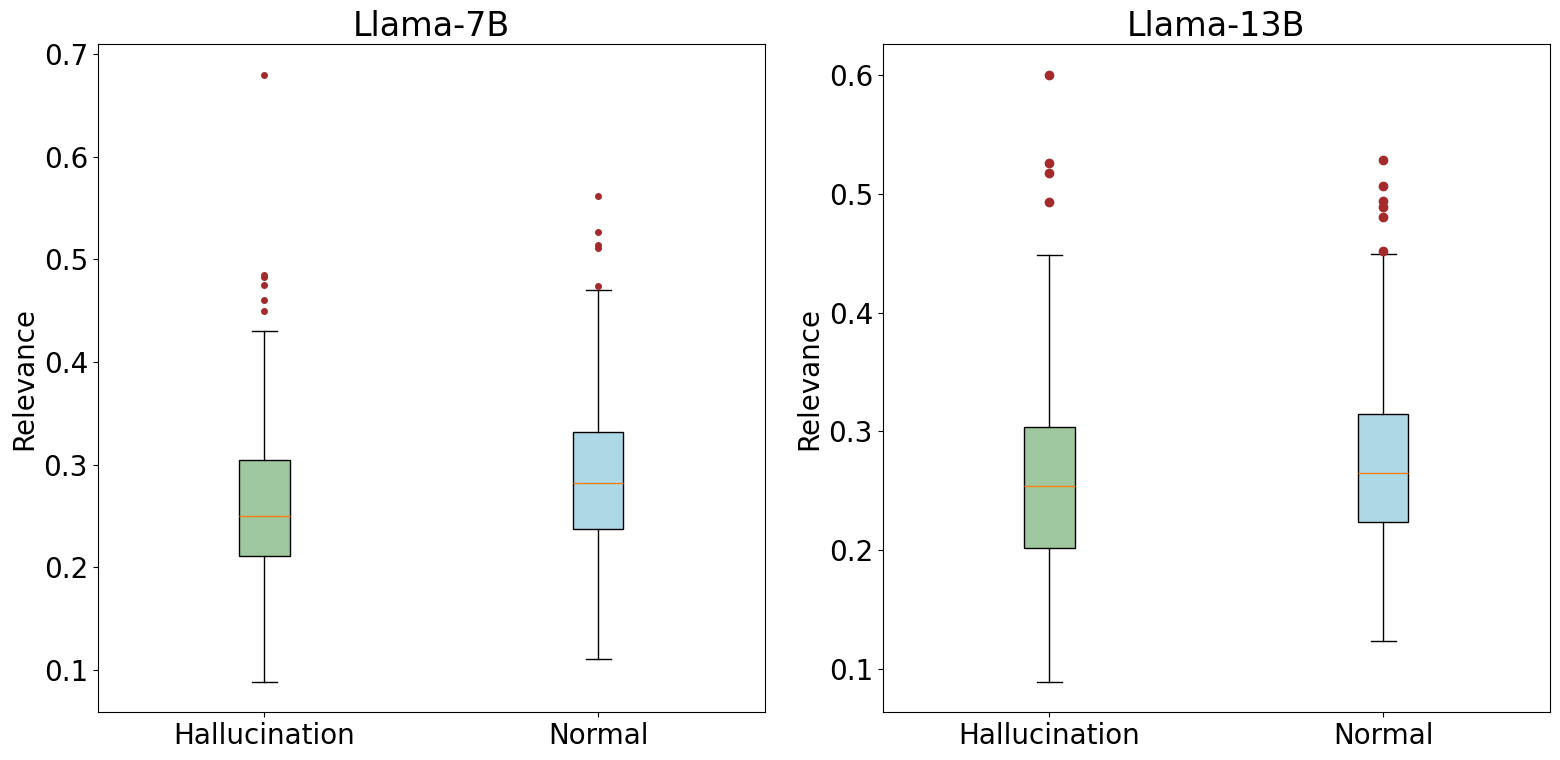

In [26]:
# 箱线图
h_contributions_s_box=[sum(normalize(x[5:-5]))/100 for x in h_contributions_s]
h_contributions_d_box=[sum(normalize(x[5:-5]))/100 for x in h_contributions_d]
nonh_contributions_s_box=[sum(normalize(x[5:-5]))/100 for x in nonh_contributions_s]
nonh_contributions_d_box=[sum(normalize(x[5:-5]))/100 for x in nonh_contributions_d]

h_contributions_s_box2=[sum(normalize(x[5:-5]))/100 for x in h_contributions_s2]
h_contributions_d_box2=[sum(normalize(x[5:-5]))/100 for x in h_contributions_d2]
nonh_contributions_s_box2=[sum(normalize(x[5:-5]))/100 for x in nonh_contributions_s2]
nonh_contributions_d_box2=[sum(normalize(x[5:-5]))/100 for x in nonh_contributions_d2]

# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 创建箱线图数据
data = [h_contributions_s_box,nonh_contributions_s_box]
colors=['#A0C8A0', 'lightblue',  '#A0C8A0','lightblue',]

data2 = [h_contributions_s_box2,nonh_contributions_s_box2]

# 创建箱线图
bp=axes[0].boxplot(data, labels=['Hallucination', 'Normal'], patch_artist=True)\
# 设置箱线图的颜色
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
# 自定义异常值的样式
plt.setp(bp['fliers'], marker='o', markersize=4, markerfacecolor='brown', markeredgecolor='brown')
plt.rcParams['font.size'] = 20

# 添加标题和轴标签
# axes[0].set_xlabel('Hallucination/Normal')
axes[0].set_ylabel('Relevance')
axes[0].set_title('Llama-7B')

# 创建箱线图
bp2=axes[1].boxplot(data2, labels=['Hallucination', 'Normal'], patch_artist=True)\
    # 设置箱线图的颜色
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    
# 自定义异常值的样式
plt.setp(bp2['fliers'], marker='o', markersize=6, markerfacecolor='brown', markeredgecolor='brown')

# 添加标题和轴标签
# axes[1].set_xlabel('Hallucination/Normal')
axes[1].set_ylabel('Relevance')
axes[1].set_title('Llama-13B')

# 显示图形
plt.tight_layout()

plt.savefig('../pdf/box.pdf')
# 显示图形
plt.show()

In [42]:
import numpy as np

def random_sample_rows(array, size):
    """
    从二维数组中随机抽取指定数量的行。

    :param array: 二维数组
    :param num_samples: 抽取的行数
    :return: 包含随机抽取行的新数组
    """
    # 获取第一个维度的长度
    num_rows = len(array)

    # 随机选择行索引
    selected_rows = np.random.choice(num_rows, size=size, replace=False)

    # 根据选中的行索引获取对应的行
    sample = list(np.array(array)[selected_rows])

    return sample


In [30]:
import numpy as np
from scipy.stats import mannwhitneyu

# U检验
h_contributions_s_mannwhitneyu=[normalize(x[5:-5]) for x in h_contributions_s]
h_contributions_d_mannwhitneyu=[normalize(x[5:-5]) for x in h_contributions_d]
nonh_contributions_s_mannwhitneyu=[normalize(x[5:-5]) for x in nonh_contributions_s]
nonh_contributions_d_mannwhitneyu=[normalize(x[5:-5]) for x in nonh_contributions_d]

h_contributions_s_mannwhitneyu2=[normalize(x[5:-5]) for x in h_contributions_s2]
h_contributions_d_mannwhitneyu2=[normalize(x[5:-5]) for x in h_contributions_d2]
nonh_contributions_s_mannwhitneyu2=[normalize(x[5:-5]) for x in nonh_contributions_s2]
nonh_contributions_d_mannwhitneyu2=[normalize(x[5:-5]) for x in nonh_contributions_d2]

mannwhitneyu_median_hs=[]
mannwhitneyu_median_nonhs=[]
mannwhitneyu_median_hs2=[]
mannwhitneyu_median_nonhs2=[]

for _ in range(50):
    
    # 对每一列进行Mann-Whitney U检验
    results = []
    for col1, col2 in zip(random_sample_rows(h_contributions_s_mannwhitneyu,size=100), random_sample_rows(nonh_contributions_s_mannwhitneyu,size=100)):
        statistic, pvalue = mannwhitneyu(np.array(col1), np.array(col2), alternative='two-sided')
        results.append((statistic, pvalue))
    
    # 求平均
    print(f"source relevance llama-7b: avg pvalue is {sum([x[1] for x in results])/len(results)}, min pvalue is {min([x[1] for x in results])}, max pvalue is {max([x[1] for x in results])}, median pvalue is {np.median([x[1] for x in results])}")
    
    mannwhitneyu_median_hs.append(np.median([x[1] for x in results]))
    
    # 对每一列进行Mann-Whitney U检验
    results = []
    for col1, col2 in zip(random_sample_rows(h_contributions_d_mannwhitneyu,size=200), random_sample_rows(nonh_contributions_d_mannwhitneyu,size=200)):
        statistic, pvalue = mannwhitneyu(np.array(col1), np.array(col2), alternative='two-sided')
        results.append((statistic, pvalue))
    
    # 求平均
    print(f"response relevance llama-7b avg pvalue is {sum([x[1] for x in results])/len(results)}, min pvalue is {min([x[1] for x in results])}, max pvalue is {max([x[1] for x in results])}, median pvalue is {np.median([x[1] for x in results])}")
    
    mannwhitneyu_median_nonhs.append(np.median([x[1] for x in results]))
    
    # 对每一列进行Mann-Whitney U检验
    results = []
    for col1, col2 in zip(random_sample_rows(h_contributions_s_mannwhitneyu2,size=200), random_sample_rows(nonh_contributions_s_mannwhitneyu2,size=200)):
        statistic, pvalue = mannwhitneyu(np.array(col1), np.array(col2), alternative='two-sided')
        results.append((statistic, pvalue))
    
    # 求平均
    print(f"source relevance llama-13b avg pvalue is {sum([x[1] for x in results])/len(results)}, min pvalue is {min([x[1] for x in results])}, max pvalue is {max([x[1] for x in results])}, median pvalue is {np.median([x[1] for x in results])}")
    
    mannwhitneyu_median_hs2.append(np.median([x[1] for x in results]))
    
    # 对每一列进行Mann-Whitney U检验
    results = []
    for col1, col2 in zip(random_sample_rows(h_contributions_d_mannwhitneyu2,size=200), random_sample_rows(nonh_contributions_d_mannwhitneyu2,size=200)):
        statistic, pvalue = mannwhitneyu(np.array(col1), np.array(col2), alternative='two-sided')
        results.append((statistic, pvalue))
    
    # 求平均
    print(f"response relevance llama-13b avg pvalue is {sum([x[1] for x in results])/len(results)}, min pvalue is {min([x[1] for x in results])}, max pvalue is {max([x[1] for x in results])}, median pvalue is {np.median([x[1] for x in results])}")
    
    mannwhitneyu_median_nonhs2.append(np.median([x[1] for x in results]))


NameError: name 'h_contributions_s2' is not defined

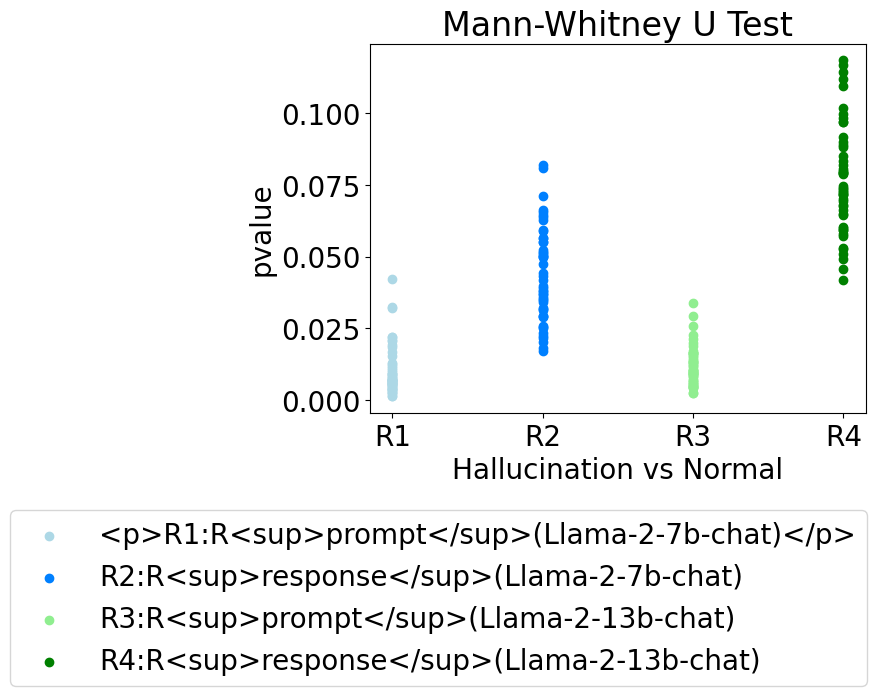

In [47]:
# 散点图
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20

# 绘制散点图
plt.scatter(['R1']*len(mannwhitneyu_median_hs), mannwhitneyu_median_hs, color='lightblue', label='R1:Rprompt(Llama-2-7b-chat)')
plt.scatter(['R2']*len(mannwhitneyu_median_nonhs), mannwhitneyu_median_nonhs, color='#0080FF', label='R2:Rresponse(Llama-2-7b-chat)')
plt.scatter(['R3']*len(mannwhitneyu_median_hs2), mannwhitneyu_median_hs2, color='lightgreen', label='R3:Rprompt(Llama-2-13b-chat)')
plt.scatter(['R4']*len(mannwhitneyu_median_nonhs2), mannwhitneyu_median_nonhs2, color='green', label='R4:Rresponse(Llama-2-13b-chat)')

# 设置横坐标为字符串
# plt.xticks(ticks=range(len(x_labels)), labels=x_labels)

# 设置图表标题和坐标轴标签
plt.title('Mann-Whitney U Test')
plt.xlabel('Hallucination vs Normal')
plt.ylabel('pvalue')

# 添加图例
plt.legend(loc='center right', bbox_to_anchor=(1.03, -0.5))
plt.savefig('../pdf/mannwhitneyu_median_pvalue.pdf', bbox_inches='tight')

# 显示图表
plt.show()

NameError: name 'h_contributions_s_mean2' is not defined

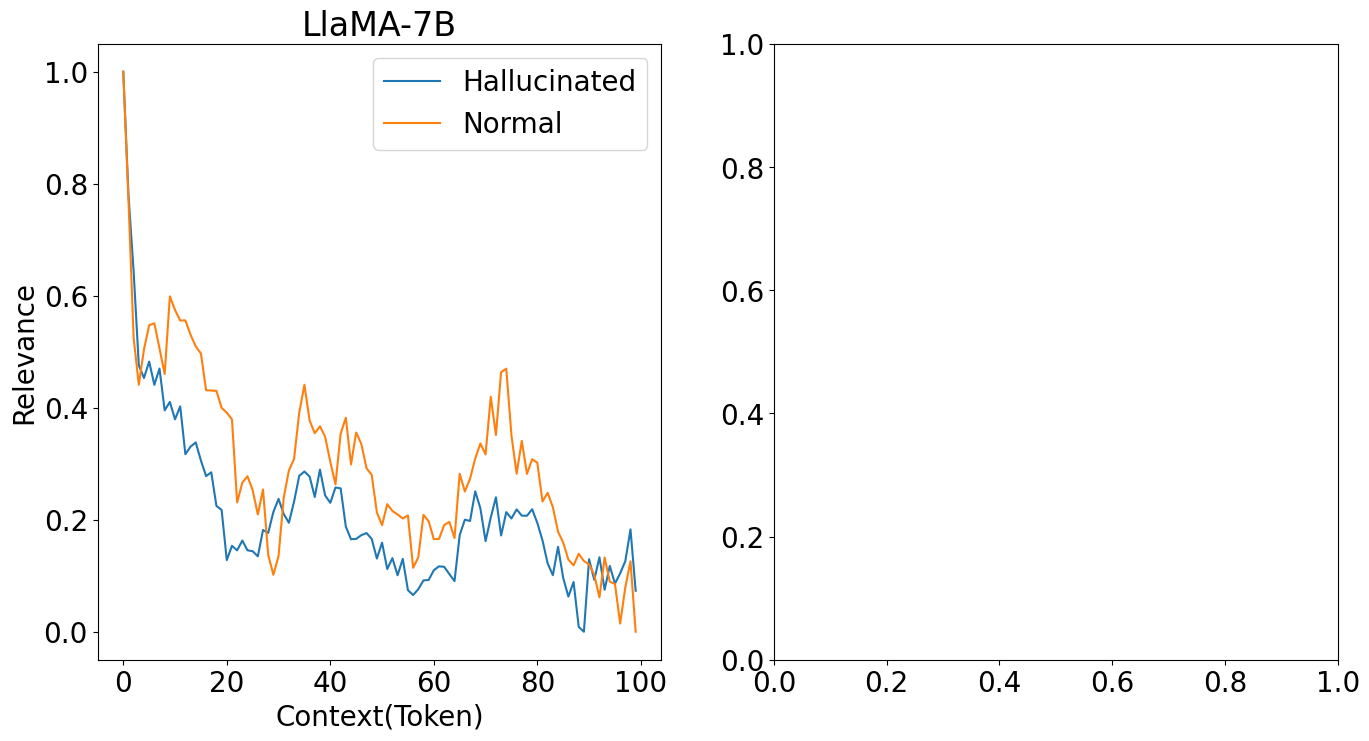

In [29]:
! pip install matplotlib
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20

h_contributions_s_mean=normalize(h_contributions_s_mean)
nonh_contributions_s_mean=normalize(nonh_contributions_s_mean)
h_contributions_d_mean=normalize(h_contributions_d_mean)
nonh_contributions_d_mean=normalize(nonh_contributions_d_mean)
# 创建图形
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
# 设置标题
axs[0].set_title('LlaMA-7B')
axs[0].set_xlabel('Context(Token)')
axs[0].set_ylabel('Relevance')
# 归一化矩阵
axs[0].plot(range(len(h_contributions_s_mean)), h_contributions_s_mean,label='Hallucinated')
axs[0].plot(range(len(nonh_contributions_s_mean)), nonh_contributions_s_mean,label='Normal')
axs[0].legend()

# axs[0][1].set_title('Response Relevance(LlaMA-7B)')
# axs[0][1].set_xlabel('Response Tokens')
# axs[0][1].set_ylabel('Relevance')
# # 归一化矩阵
# axs[0][1].plot(range(len(h_contributions_d_mean)), h_contributions_d_mean,label='Hallucinated Samples')
# axs[0][1].plot(range(len(nonh_contributions_d_mean)), nonh_contributions_d_mean,label='Normal Samples')
# axs[0][1].legend()

h_contributions_s_mean2=normalize(h_contributions_s_mean2)
nonh_contributions_s_mean2=normalize(nonh_contributions_s_mean2)
h_contributions_d_mean2=normalize(h_contributions_d_mean2)
nonh_contributions_d_mean2=normalize(nonh_contributions_d_mean2)

# 设置标题
axs[1].set_title('LlaMA-13B')
axs[1].set_xlabel('Context(Token)')
# axs[1].set_ylabel('Relevance')
# 归一化矩阵
axs[1].plot(range(len(h_contributions_s_mean2)), h_contributions_s_mean2,label='Hallucination')
axs[1].plot(range(len(nonh_contributions_s_mean2)), nonh_contributions_s_mean2,label='Normal')
axs[1].legend()

# axs[1][1].set_title('Response Relevance(LlaMA-13B)')
# axs[1][1].set_xlabel('Response Tokens')
# axs[1][1].set_ylabel('Relevance')
# # 归一化矩阵
# axs[1][1].plot(range(len(h_contributions_d_mean2)), h_contributions_d_mean2,label='Hallucinated Samples')
# axs[1][1].plot(range(len(nonh_contributions_d_mean2)), nonh_contributions_d_mean2,label='Normal Samples')
# axs[1][1].legend()

plt.savefig('../pdf/line.pdf', format='pdf')
plt.show()


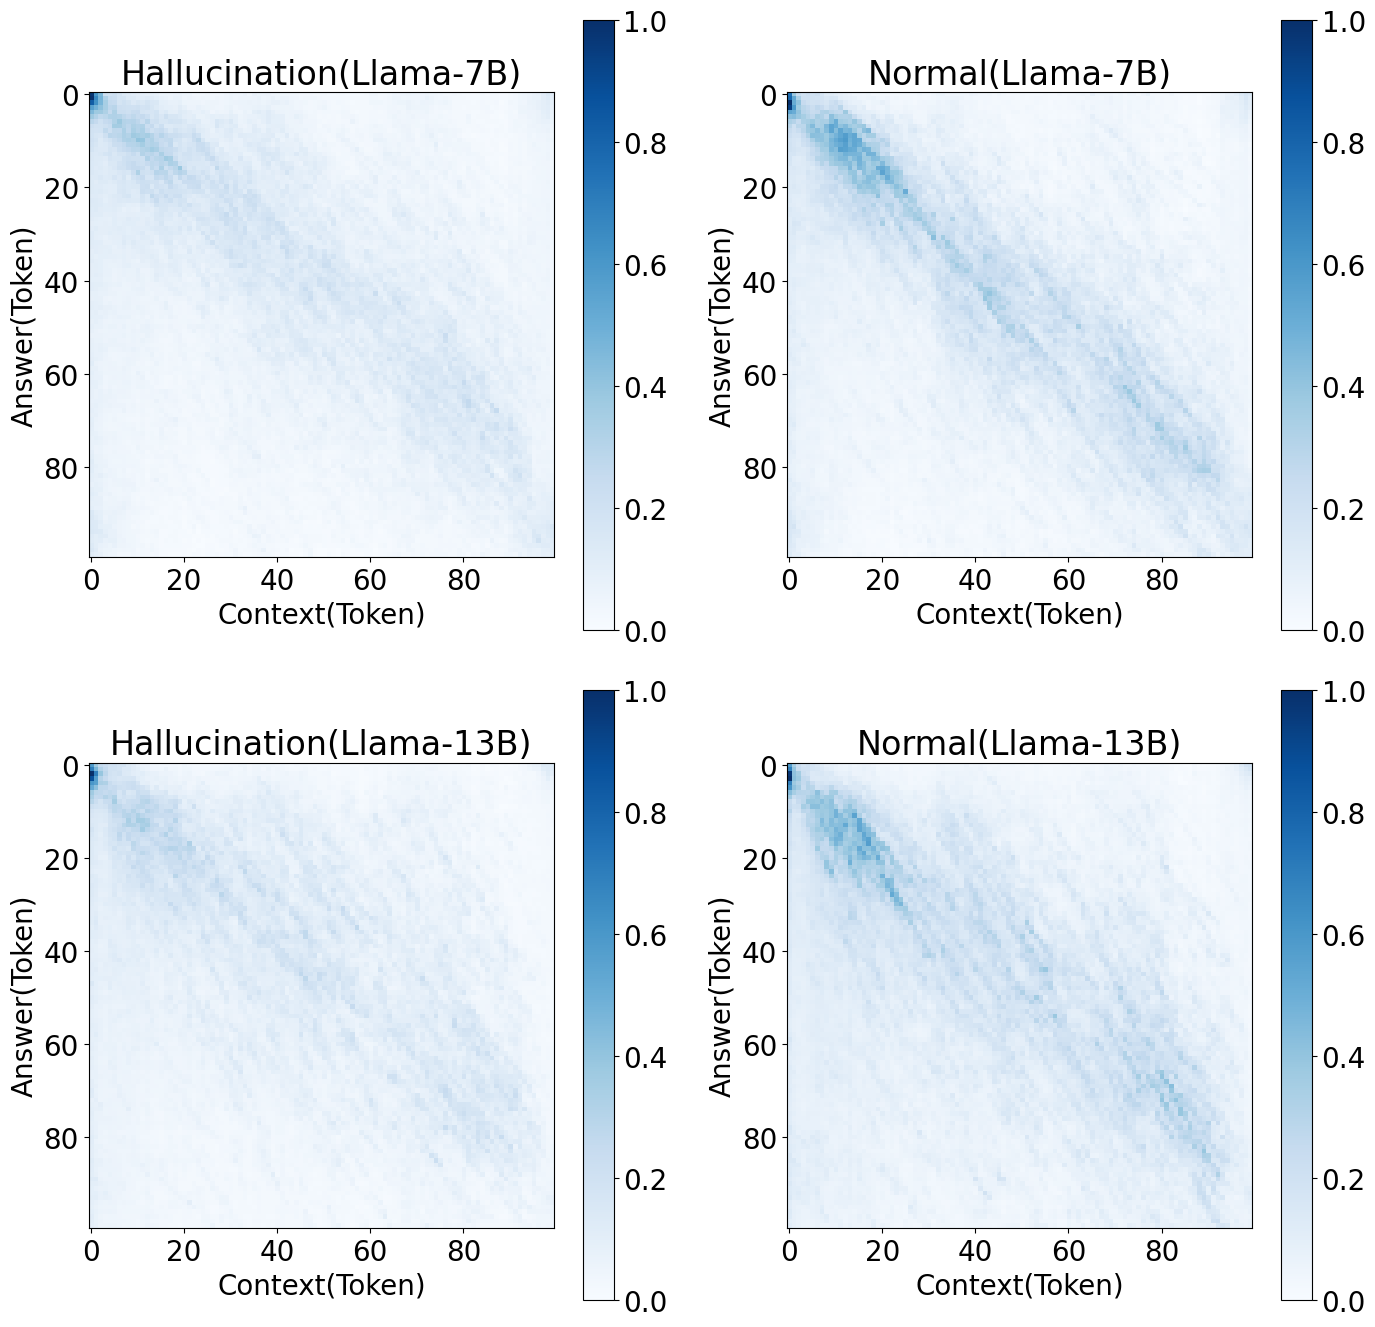

In [33]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20

# 创建图形
fig, axs = plt.subplots(2, 2, figsize=(16, 16))
# 归一化矩阵

# 绘制热力图
im = axs[0][0].imshow(normalize(h_contributions_mean), cmap="Blues")  

# 设置标题
axs[0][0].set_title('Hallucination(Llama-7B)')
axs[0][0].set_xlabel('Context(Token)')
axs[0][0].set_ylabel('Answer(Token)')
fig.colorbar(im, ax=axs[0][0])
# 绘制热力图
im2 = axs[0][1].imshow(normalize(nonh_contributions_mean), cmap="Blues")

# 设置标题
axs[0][1].set_title('Normal(Llama-7B)')
axs[0][1].set_xlabel('Context(Token)')
axs[0][1].set_ylabel('Answer(Token)')

# 添加颜色条
fig.colorbar(im2, ax=axs[0][1])

# 绘制热力图
im3 = axs[1][0].imshow(normalize(h_contributions_mean2), cmap="Blues")

# 设置标题
axs[1][0].set_title('Hallucination(Llama-13B)')
axs[1][0].set_xlabel('Context(Token)')
axs[1][0].set_ylabel('Answer(Token)')

# 添加颜色条
fig.colorbar(im3, ax=axs[1][0])


# 绘制热力图
im3 = axs[1][1].imshow(normalize(nonh_contributions_mean2), cmap="Blues")

# 设置标题
axs[1][1].set_title('Normal(Llama-13B)')
axs[1][1].set_xlabel('Context(Token)')
axs[1][1].set_ylabel('Answer(Token)')

# 添加颜色条
fig.colorbar(im3, ax=axs[1][1])
# 调整边距
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.1)

# 显示图形
plt.savefig("../pdf/hotmap.pdf")
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
labels = ['Generation', 'LRP backward', 'Context pruning', 'Hallucination detection']
left_times = [
    0.045 * 70.81,  # Generation
    0.131 * 70.81,
    0.039 * (84.07 + 96.16),  
    1.723  # Hallucination Detection
]
right_times = [
    0.045 * 70.81,  # Generation
    0.131 * 70.81,
    0,  # Context pruning
    1.218  # Hallucination Detection
]

# 设置图形大小
plt.figure(figsize=(10, 6))

# 定义柱状图的位置
x = np.arange(len(labels))
width = 0.35  # 柱状图的宽度

# 绘制左侧柱状图
plt.bar(x - width/2, left_times, width, label=r'$LRP4RAG_{LLM}$',color='lightblue')

# 绘制右侧柱状图
plt.bar(x + width/2, right_times, width, label=r'$LRP4RAG_{Classifier}$',color='orange')
print(sum(left_times),sum(right_times),sum(left_times)/sum(right_times))
# 添加标签和标题
plt.ylabel('Time (seconds)',fontsize=12)
plt.xticks(x, labels,fontsize=12)
plt.legend()
plt.savefig("../pdf/time.pdf")
# 显示图形
plt.show()


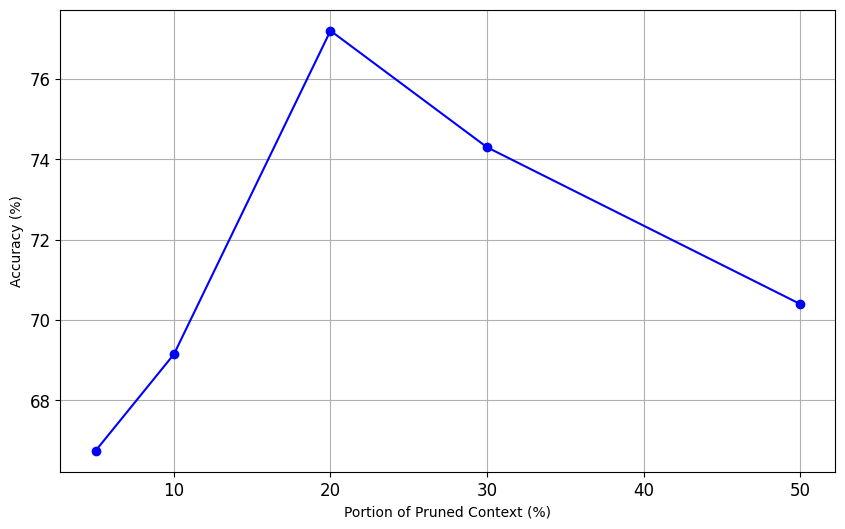

In [22]:
import matplotlib.pyplot as plt

# 数据
x = [5, 10, 20, 30, 50]
y = [66.75, 69.15, 77.2, 74.3, 70.4]

# 设置图形大小
plt.figure(figsize=(10, 6))

# 绘制折线图
plt.plot(x, y, marker='o', linestyle='-', color='blue')

# 添加标题和标签
plt.xlabel('Portion of Pruned Context (%)')
plt.ylabel('Accuracy (%)')

# 设置刻度字体大小
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 显示网格
plt.grid(True)

# 保存图形
plt.savefig("../pdf/accuracy_vs_context_length.pdf")

# 显示图形
plt.show()
